# Computer Vision Project

### Setup

In [59]:
import os                           # type: ignore
import numpy as np                  # type: ignore
import cv2                          # type: ignore
import matplotlib.pyplot as plt     # type: ignore
import pandas as pd                 # type: ignore
import albumentations as albu       # type: ignore
import importlib

# Custom modules
import segmentation as seg
importlib.reload(seg)

<module 'segmentation' from '/Users/georgeboutselis/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Year 4/Semester 2/Computer Vision/Computer-Vision-Project/segmentation.py'>

In [62]:
# Defining some constants that will be used throughout the notebook
CLASSES = ['dog', 'cat', 'background']
DATA_DIR = '/Users/georgeboutselis/Library/CloudStorage/GoogleDrive-boutselisgeorgea@gmail.com/My Drive/Dataset'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [63]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = seg.preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = seg.preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [67]:
train_dataset = seg.CVDataset(x_train_fps, y_train_fps)
valid_dataset = seg.CVDataset(x_val_fps, y_val_fps)
test_dataset  = seg.CVDataset(x_test_fps, y_test_fps)


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2944
Validation dataset has size 736
Testing dataset has size 3711


### Custum visualisation function example

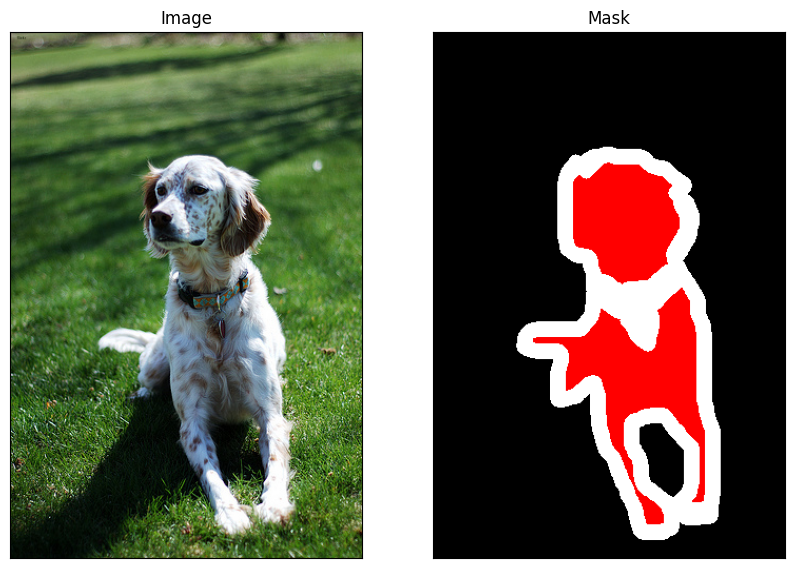

In [68]:
image, mask = test_dataset[2000]
seg.show.visualiseData(image = image, mask = mask)

### Preprocessing and data augmentations

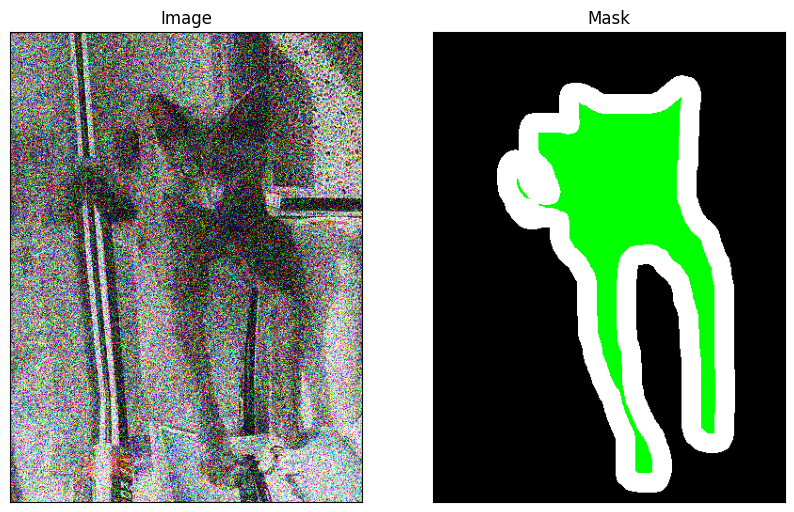

In [75]:
train_augmentation = seg.preprocessing.get_training_augmentation()
augmented_dataset = seg.CVDataset(x_train_fps , y_train_fps, augmentation = train_augmentation)
image, mask = augmented_dataset[100]
seg.show.visualiseData(image=image, mask = mask)